# TODOS:

In [1]:
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import MDS

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_point, theme

from utils import get_percentage_of_missing_values, plot_and_save_heatmap, encode_dataframe_to_plot_heatmap_of_missing_values, remove_by_variance_threshold

## Constants

In [2]:
DATA_PATH = "data/data_after_split/X_train.csv"
TARGETS_PATH = "data/data_after_split/y_train.csv"
INTERMEDIATE_VARIANCE_REMOVED_FILE_PATH = "data/intermediate_files/data_after_variance_removal.csv"

RANDOM_SEED = 0
FIGSIZE = (22, 12)
PERCENTAGE_OF_MISSING_VALUES_THRESHOLD = 3
HEATMAP_COLOR_PALETTE = ["#f5f2f2", "#000000"]
CORRELATION_THRESHOLD = 0.90
VARIANCE_THRESHOLD = 0.10

## Preprocessing, 

- load data
- convert all values to integer

In [18]:
data = pd.read_csv(DATA_PATH, index_col=0).astype(np.int64)
targets = pd.read_csv(TARGETS_PATH)
data.shape

(678, 25757)

## NA's handling

- based on heatmap we decide to remove snp's that have over 30% missing values

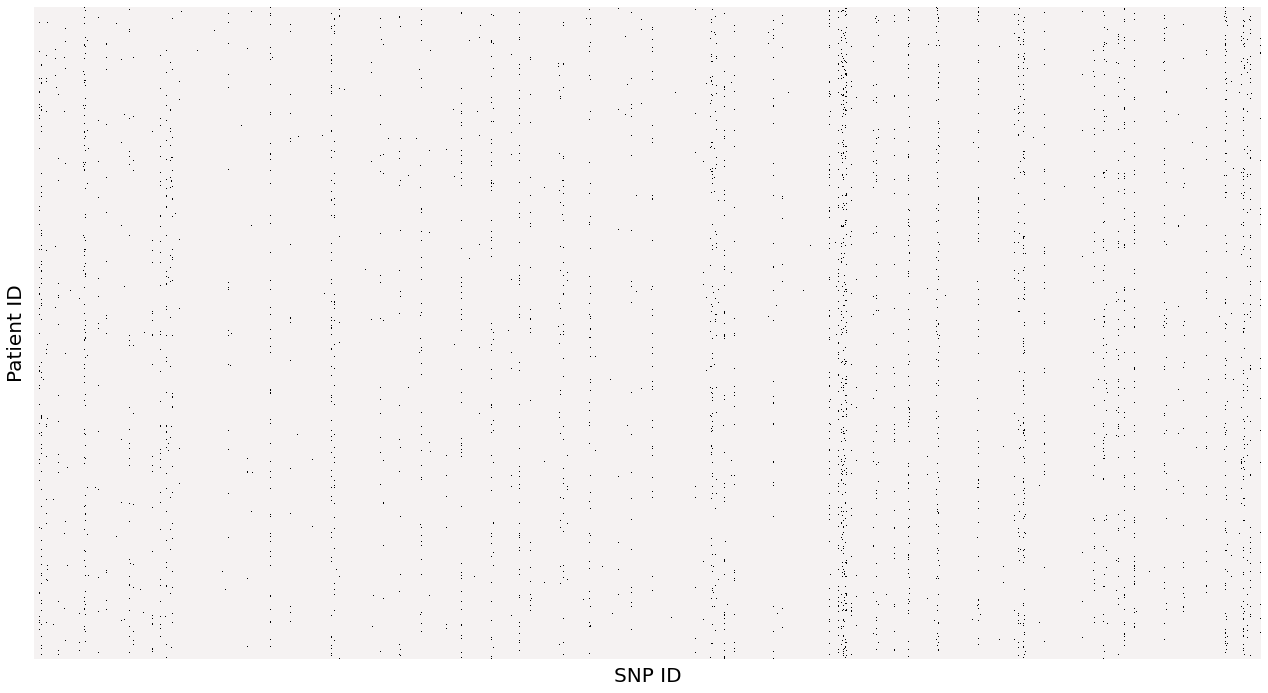

In [4]:
na_dataframe_to_plot = encode_dataframe_to_plot_heatmap_of_missing_values(data)
plot_and_save_heatmap(na_dataframe_to_plot, FIGSIZE, HEATMAP_COLOR_PALETTE, filename="heatmap_before_processing")

In [5]:
data = data.replace(-1, None)
perc = get_percentage_of_missing_values(data)
ids_to_remove = perc[perc.number_of_na > PERCENTAGE_OF_MISSING_VALUES_THRESHOLD].index.values

In the dataset there is 678 rows


In [6]:
data = data.drop(ids_to_remove, axis=1)

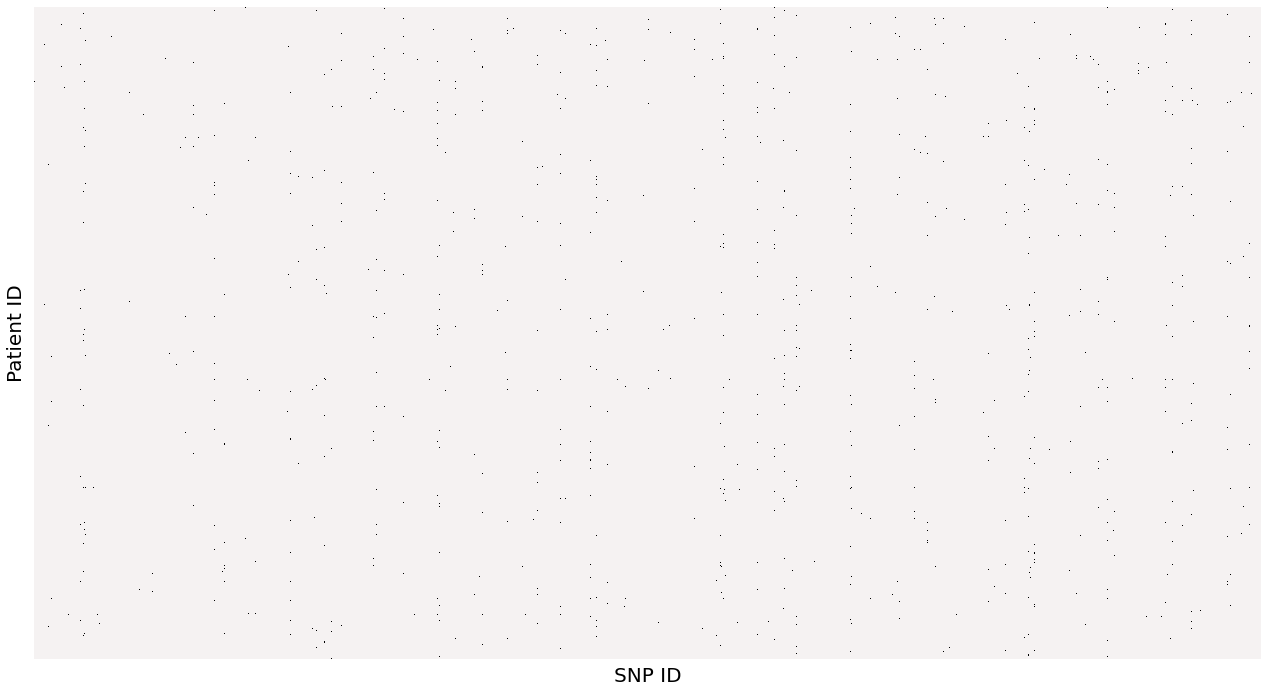

In [7]:
na_dataframe_to_plot = encode_dataframe_to_plot_heatmap_of_missing_values(data)
plot_and_save_heatmap(na_dataframe_to_plot, FIGSIZE, HEATMAP_COLOR_PALETTE, filename="heatmap_after_removing_rows_with_30_perc_of_missing")

## Imputation

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)

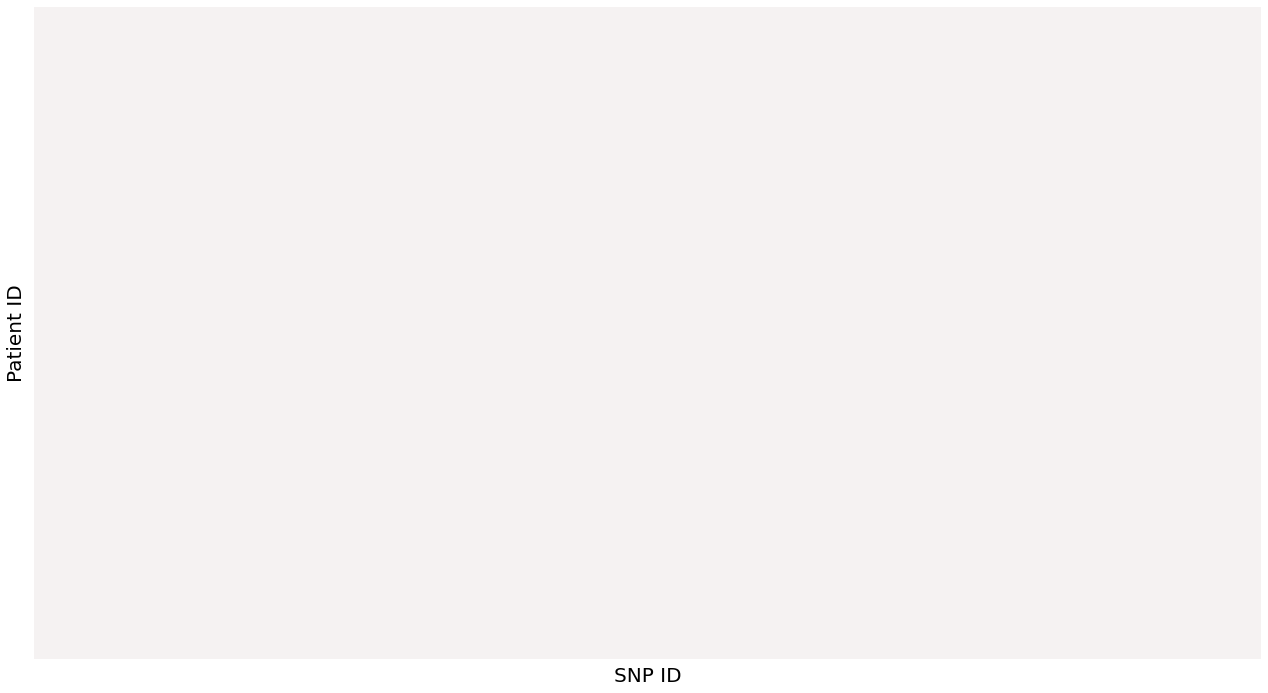

In [9]:
na_dataframe_to_plot = encode_dataframe_to_plot_heatmap_of_missing_values(data_imputed)
plot_and_save_heatmap(na_dataframe_to_plot, FIGSIZE, HEATMAP_COLOR_PALETTE, filename="heatmap_after_imputation")

## Variance handling

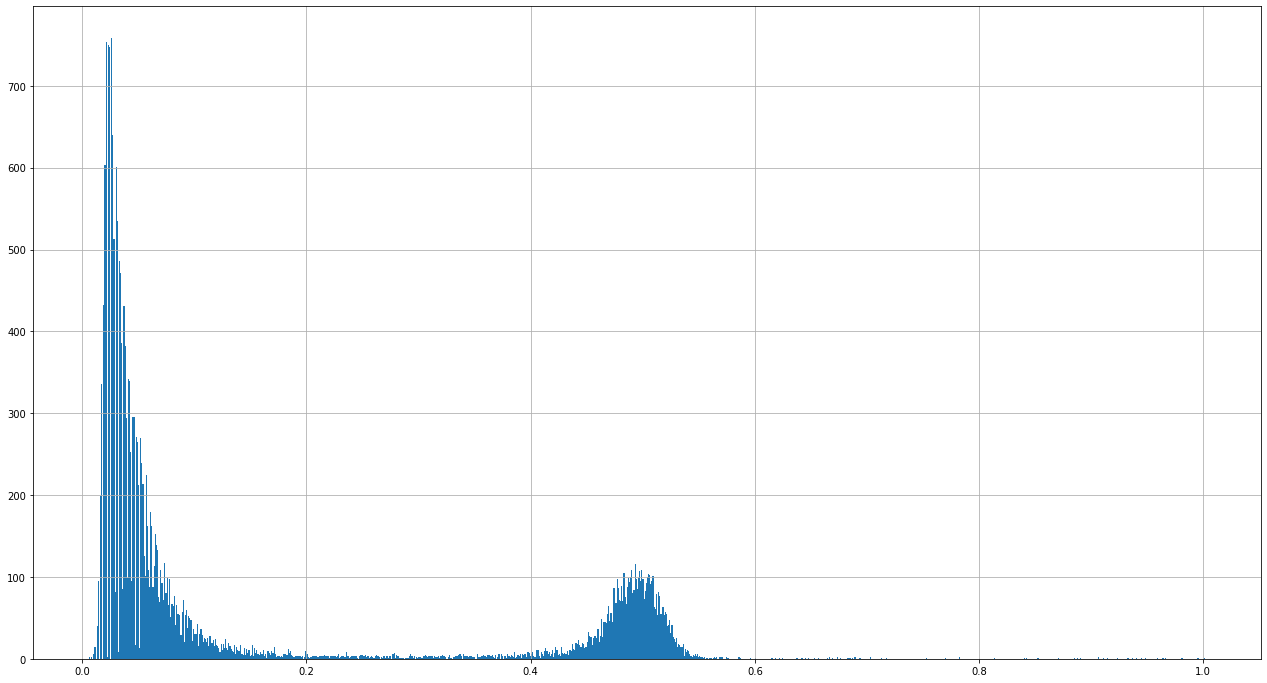

In [10]:
plt.figure(figsize = FIGSIZE)
ax = pd.DataFrame(data_imputed.var(), columns=["variance"]).variance.hist(bins=1000)
fig = ax.get_figure()
fig.savefig('plots/variance_distribution.png')

In [11]:
variance_removed = remove_by_variance_threshold(data_imputed, VARIANCE_THRESHOLD)

In [19]:
variance_removed.shape

(678, 7700)

In [12]:
variance_removed.to_csv(INTERMEDIATE_VARIANCE_REMOVED_FILE_PATH)

## Features correlation

In [13]:
variance_removed = pd.read_csv(INTERMEDIATE_VARIANCE_REMOVED_FILE_PATH, index_col=0).astype(np.int64)

In [14]:
corr_matrix = variance_removed.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORRELATION_THRESHOLD)]
highly_correlated_removed = variance_removed.drop(to_drop, axis=1)

In [20]:
highly_correlated_removed.shape

(678, 6430)

## Export dataframe to circos plot after feature selection

In [15]:
pd.Series(highly_correlated_removed.columns).to_csv("data/intermediate_files/data_after_removal_of_highly_correlated.csv", index=False)

## Plot after multidimensional scaling

In [16]:
scaler = MDS(n_components=2)
data_scaled = pd.DataFrame(scaler.fit_transform(highly_correlated_removed), columns=["Component 1", "Component 2"], index=highly_correlated_removed.index)
targets = pd.read_csv(TARGETS_PATH)
targets.index = data_scaled.index
data_to_mds_plot = pd.concat([data_scaled, targets], axis=1)

In [17]:
p = (ggplot(data_to_mds_plot, aes(x="Component 1", y="Component 2", fill="target_severity")) +
     geom_point(size=8, alpha=0.9) +
     theme(figure_size=FIGSIZE)
     
)

p.save("plots/mds_scaled.png", dpi=500)

/home/rafalstepien/environments/magisterka/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 22 x 12 in image.
/home/rafalstepien/environments/magisterka/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/mds_scaled.png


## Next steps

- selekcja Jaccard/pozycja w genomie
- performance różnych klasyfikatorów na modelach bez tuningu hiperparametrów
- performance różnych klasyfikatorów na modelach z tuningiem hiperparametrów
- porównanie wybranego klasyfikatora z dummy classifiers (random, most frequent)
- oversampling/undersampling 
- explanatory analysis
- test set performance on selected model
- krzywe uczenia (learning curves)
- rozkład prawdopodobieństw, które przewidział klasyfikator na testowym